In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy
from ydata_profiling import ProfileReport
import seaborn as sns
import missingno as miss
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
# %config InlineBackend.figure_format = 'svg'
plt.rcParams["font.family"] = "sans-serif"

# Introduction
The purpose of this assignment is to predict the first travel destination an user may book with this online travel agency.

Datasets:
1. User dataset: the basic information collected about users, e.g. sign-ups, bookings, affiliate channel etc.
2. Session dataset: data collected on sessions when users browse the website.


# Load data

In [358]:
df_users=pd.read_csv(r"data\train_users_2.csv")
df_sessions=pd.read_csv(r"data\sessions.csv")

In [359]:
df_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [360]:
df_sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [361]:
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method',
    'signup_flow'
]

for categorical_feature in categorical_features:
    df_users[categorical_feature] = df_users[categorical_feature].astype('category')

In [362]:
df_users['date_account_created'] = pd.to_datetime(df_users['date_account_created'])
df_users['timestamp_first_active'] = pd.to_datetime(df_users['timestamp_first_active'], format='%Y%m%d%H%M%S').dt.date
df_users['date_first_booking'] = pd.to_datetime(df_users['date_first_booking'])

In [363]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id                       213451 non-null  object        
 1   date_account_created     213451 non-null  datetime64[ns]
 2   timestamp_first_active   213451 non-null  object        
 3   date_first_booking       88908 non-null   datetime64[ns]
 4   gender                   213451 non-null  category      
 5   age                      125461 non-null  float64       
 6   signup_method            213451 non-null  category      
 7   signup_flow              213451 non-null  category      
 8   language                 213451 non-null  category      
 9   affiliate_channel        213451 non-null  category      
 10  affiliate_provider       213451 non-null  category      
 11  first_affiliate_tracked  207386 non-null  category      
 12  signup_app      

# Univariate analysis

## Label distribution 
1. 'NDF'(no destination found) class has the highest percentage.
2. As we are only interested in records with a destination so excluding these records.
3. After excluding 'NDF', 70% of people pick US as their first destination country followed by, 11% in 'OTHERS' where no country name was defined, and 5% in France. The Rest countries have very low percentage.
4. The dataset is very imbalanced which may require techniques like upsampling/downsampling and weighting loss may be needed.

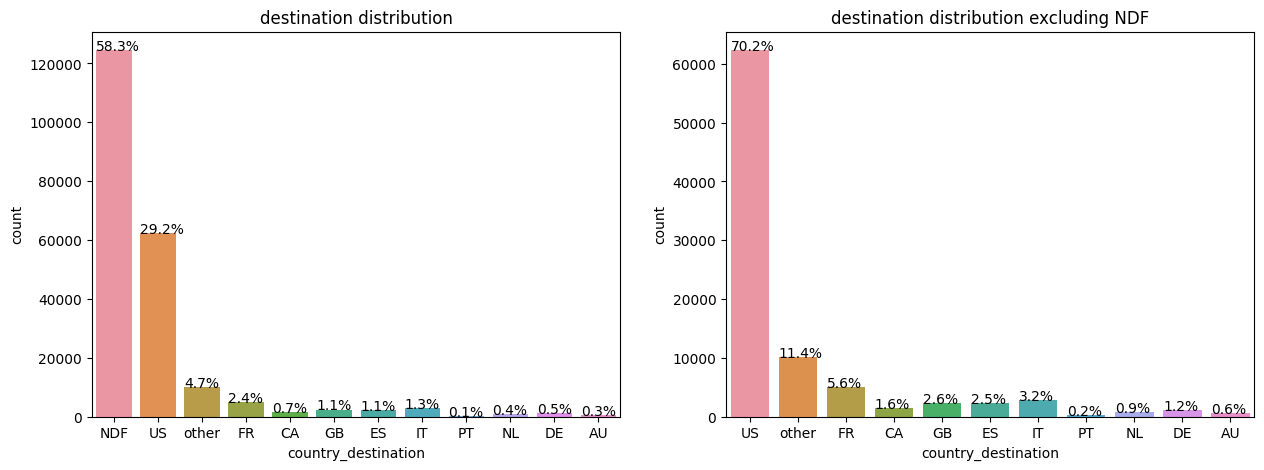

In [364]:
def plot_dist(df,col,title,p1):
    sns.countplot(df,x=col,ax=p1)
    p1.set_title(title)
    for p in p1.containers[0]:
        s="%.1f%%"%(p.get_height()*100/df[col].count())
        p1.text(p.get_x(),p.get_height(), s)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_dist(df_users,'country_destination','destination distribution',axes[0])
df_users=df_users[df_users['country_destination'] != 'NDF']
plot_dist(df_users,'country_destination','destination distribution excluding NDF',axes[1])

## Missing data 
1. 22% of 'age' data is missing followed by 2% of 'first_affiliate_tracked'.

In [365]:
df_users.isnull().sum()*100/df_users['id'].shape[0]

id                          0.000000
date_account_created        0.000000
timestamp_first_active      0.000000
date_first_booking          0.000000
gender                      0.000000
age                        22.918073
signup_method               0.000000
signup_flow                 0.000000
language                    0.000000
affiliate_channel           0.000000
affiliate_provider          0.000000
first_affiliate_tracked     1.954830
signup_app                  0.000000
first_device_type           0.000000
first_browser               0.000000
country_destination         0.000000
dtype: float64

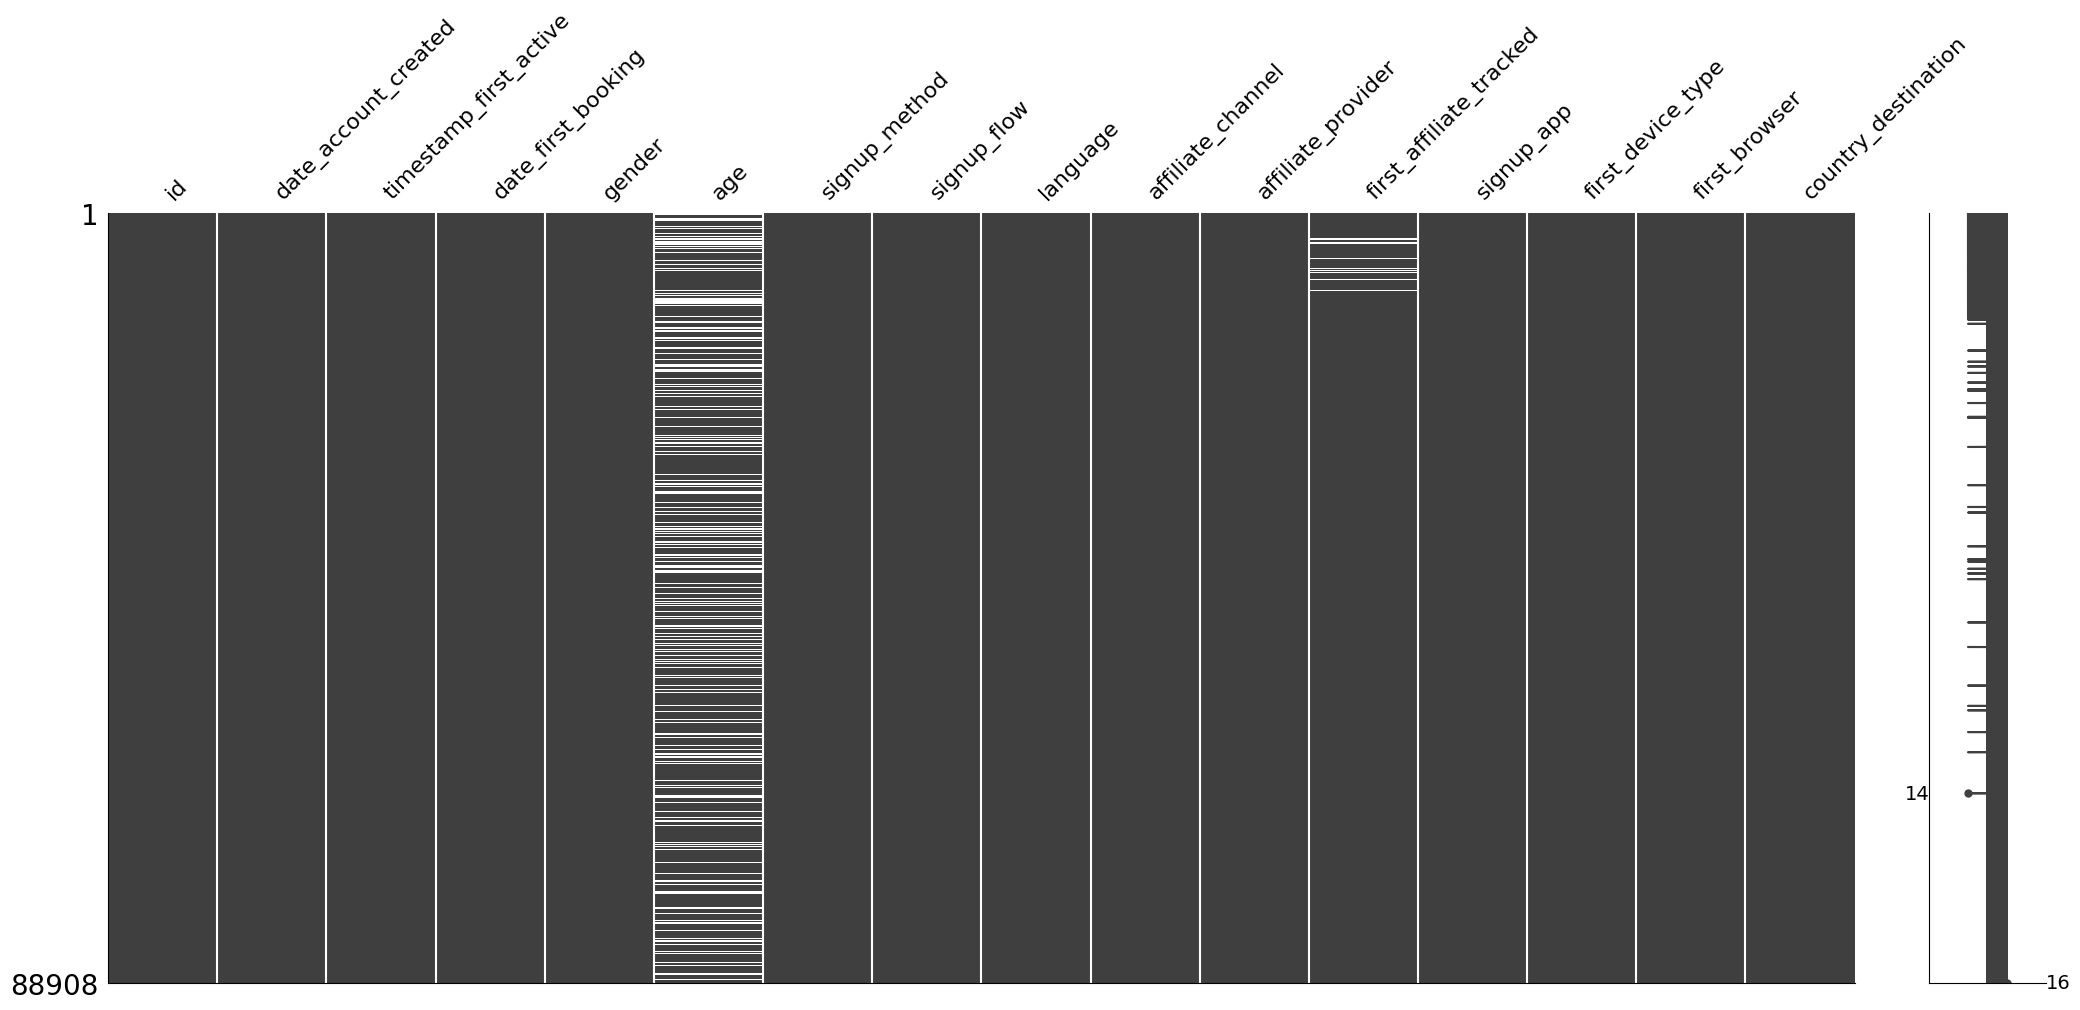

In [366]:
miss.matrix(df_users)
sns.despine()

## Age 

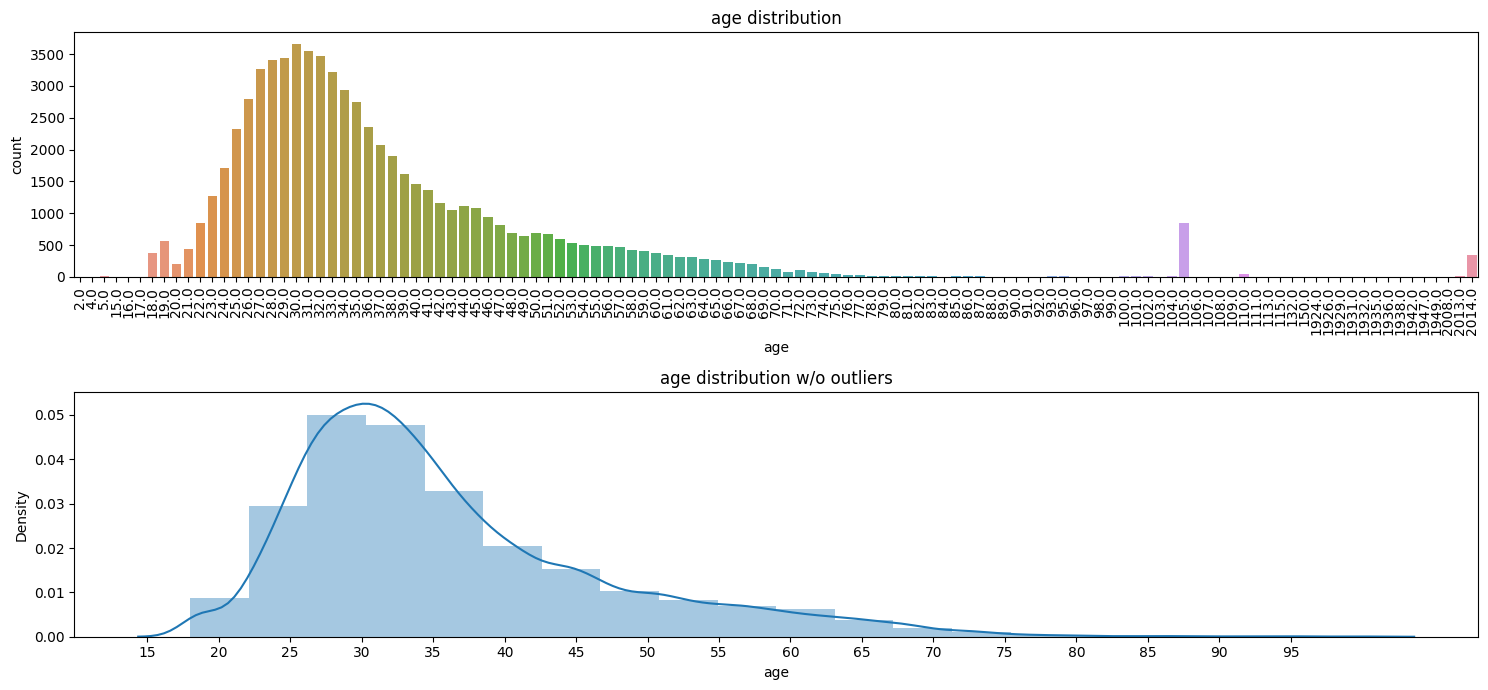

In [367]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 7))
sns.countplot(df_users,x='age',ax=axes[0])
axes[0].set_title('age distribution')
axes[0].tick_params(axis='x', labelrotation = 90)
df_users.loc[df_users.age > 100, 'age'] = np.nan
df_users.loc[df_users.age < 18, 'age'] = np.nan
sns.distplot(df_users['age'],ax=axes[1], bins=20, kde=True)
axes[1].set_title('age distribution w/o outliers')
x=plt.xticks(np.arange(15, 96, 5))
plt.tight_layout()

1. We can see some errors in the age values where the year number were inputed mistakenly.
2. After filtering out those outliers, we can see the distribution is right skewed.
3. Most people using this website for booking travels are between 20 and 40 years old.

<AxesSubplot: xlabel='country_destination', ylabel='age'>

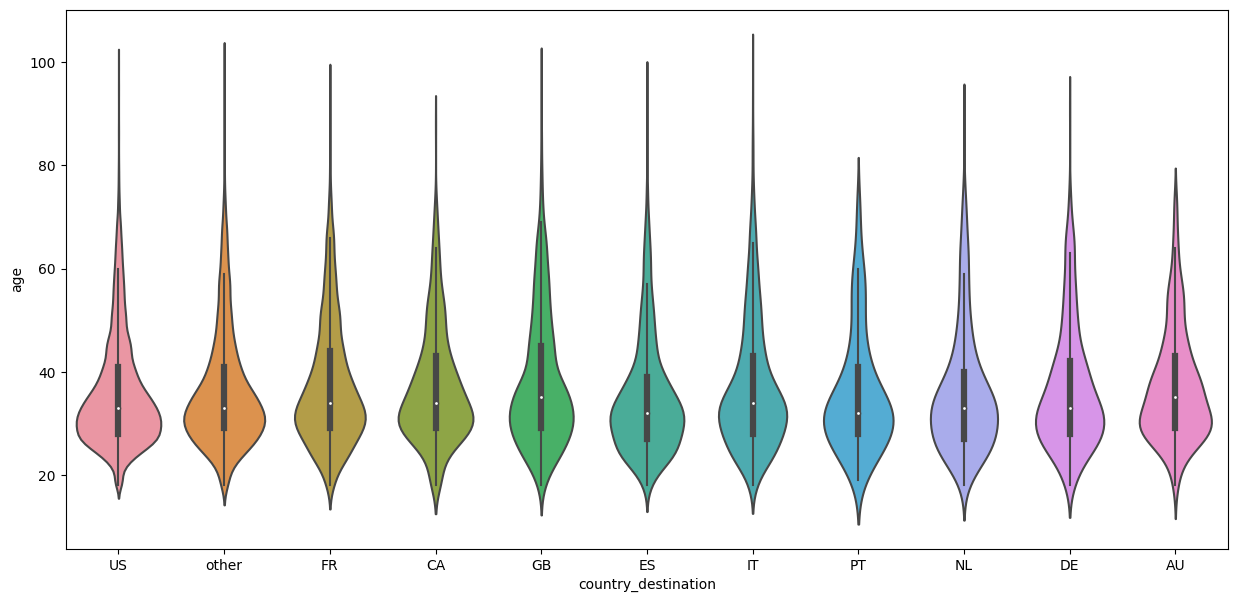

In [368]:
fig, axes = plt.subplots( figsize=(15, 7))
sns.violinplot(df_users,x='country_destination', y= 'age')

4. Users who travel to GB, IT annd AU are older the rest while users who travel to ES are usually younger.

## Gender

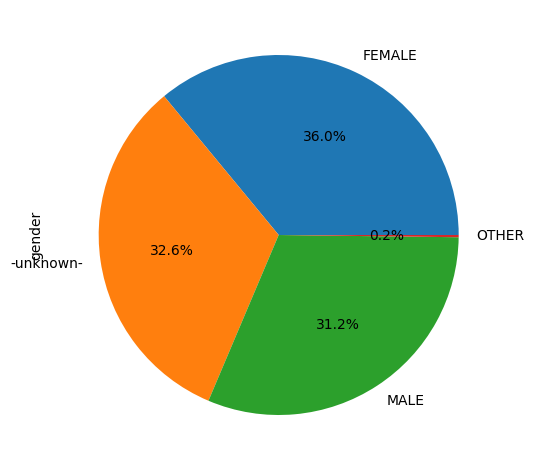

In [369]:
percentage = df_users['gender'].value_counts() / len(df_users['gender']) * 100
percentage.plot(kind='pie',autopct="%1.1f%%")
plt.tight_layout()

<AxesSubplot: xlabel='country_destination', ylabel='count'>

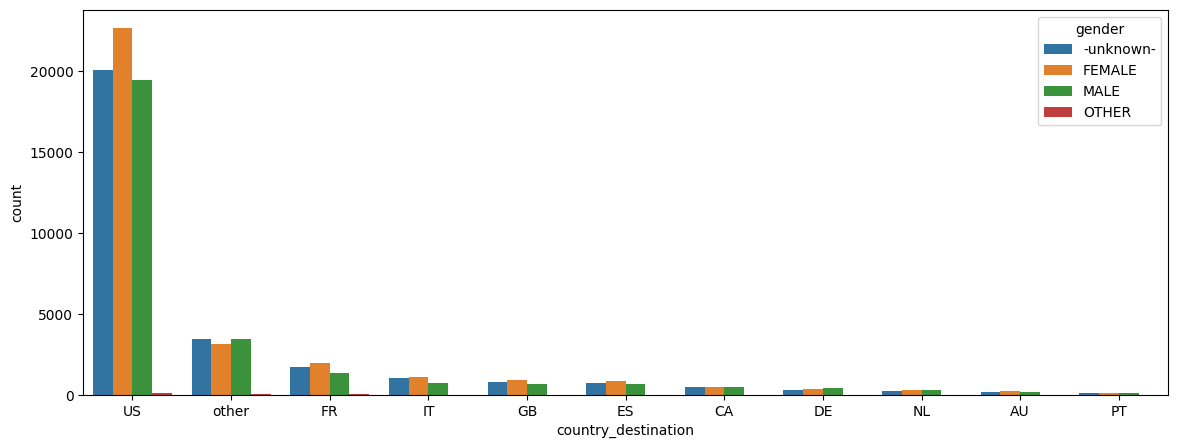

In [370]:
plt.figure(figsize=(14,5))
order1 = df_users['country_destination'].value_counts().index
sns.countplot(data =df_users, x = 'country_destination', order = order1,hue='gender')

1. Females are the majority in people who are travelling to US and FR while there is very slight difference in the rest of countries.

## Other categorical features
A few findings:

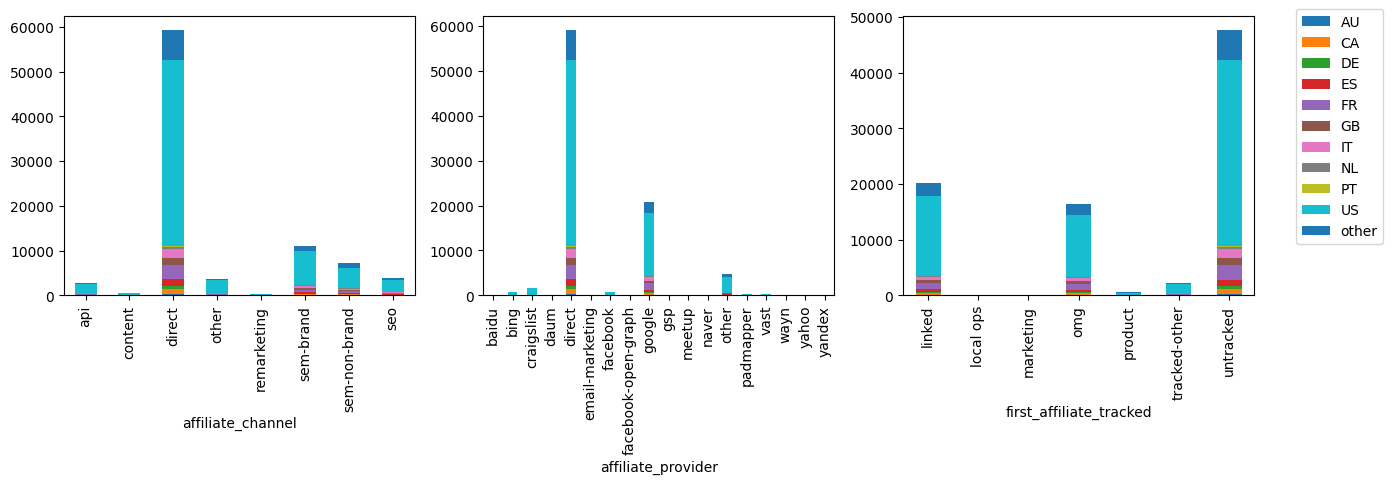

In [371]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 5), dpi=100, facecolor="w", edgecolor="k")
i=0
for col in categorical_features[0:3]:
    temp=df_users.pivot_table(index=col,columns='country_destination',values='id',aggfunc='count')
    temp.plot.bar(stacked=True,ax=axes[i])
    axes[i].tick_params('x',labelrotation=90)
    axes[i].legend([],[], frameon=False)
    i=i+1
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()

1. People tend to rearch to this website directly which may indicate the brand has a good exposure. 
2. Google is largest affiliate provider if direct is excluded.
3. Most of the first affiliate is untracked followed by linked and omg. 

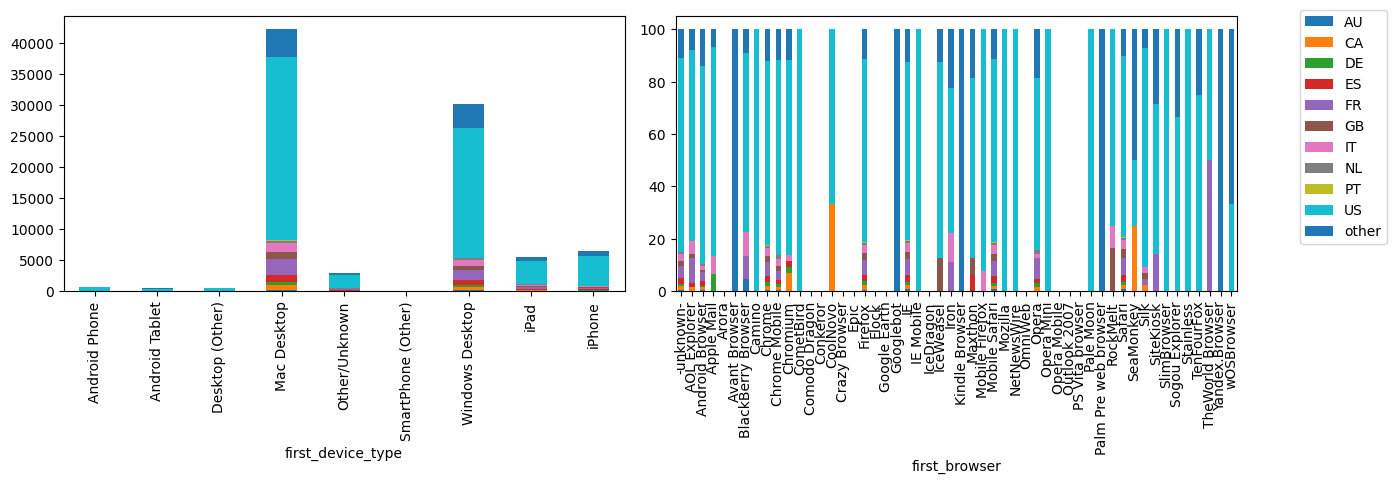

In [372]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), dpi=100, facecolor="w", edgecolor="k")
temp=df_users.pivot_table(index=['first_device_type'],columns='country_destination',values='id',aggfunc='count')
temp.plot.bar(stacked=True,ax=axes[0])
axes[0].tick_params('x',labelrotation=90)
axes[0].legend([],[], frameon=False)

temp=df_users.pivot_table(index=['first_browser'],columns='country_destination',values='id',aggfunc='count').apply(lambda x: x/x.sum() * 100, axis=1)
temp.plot.bar(stacked=True,ax=axes[1])
axes[1].tick_params('x',labelrotation=90)

plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()

1. Majority of people like to make bookings on desktops.
2. Browser Cooinovo is popular in CA while Theworld browser is mostly used in FR comparing the rest of countries.

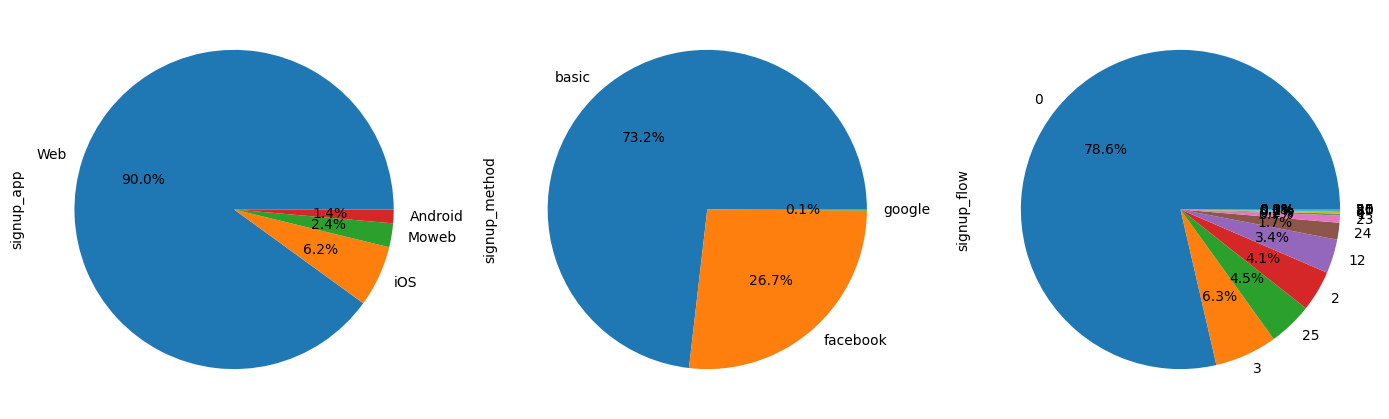

In [373]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 5), dpi=100, facecolor="w", edgecolor="k")
i=0
for col in categorical_features[-3:]:
    percentage = df_users[col].value_counts() / len(df_users[col]) * 100
    percentage.plot(kind='pie',autopct="%1.1f%%",ax=axes[i])
    i+=1
plt.tight_layout()

1. Most of signups are done in web app followed by iOS.
2. Basic and facebook take up about 90% in signup method.
3. Flow_0 is the most used signup flow.

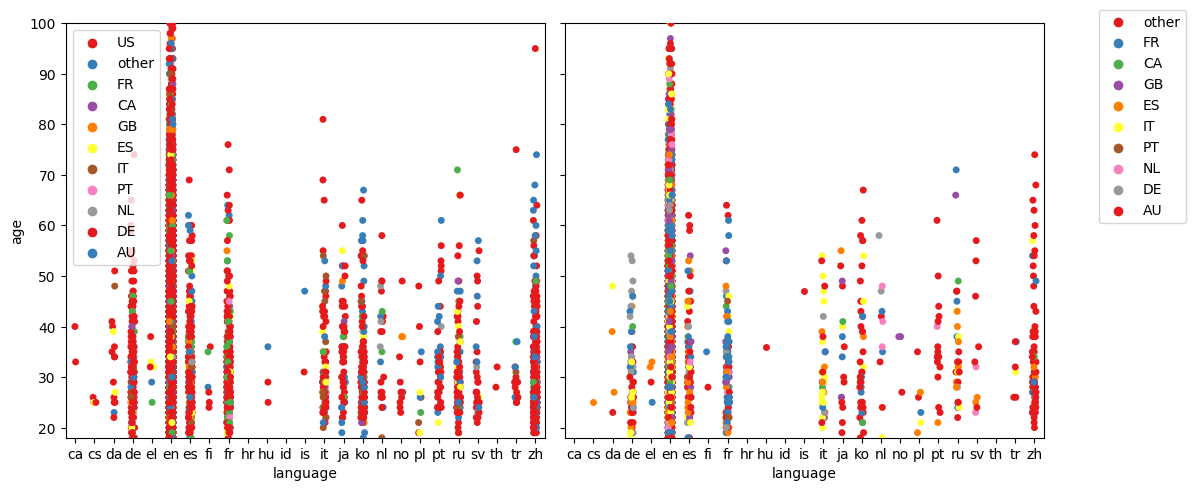

In [374]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=100, facecolor="w", edgecolor="k",sharey=True)
sns.stripplot(x="language", y="age", data=df_users,hue='country_destination',palette='Set1',ax=axes[0])
axes[0].legend()
sns.stripplot(x="language", y="age", data=df_users[df_users['country_destination']!='US'],hue='country_destination',palette='Set1',ax=axes[1])
plt.ylim(18,100)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()

1. English speakers travel a lot to US but also to most of countries.
2. People speak the other language tend to travel to the homeland more frequent.

# Bivariate analysis


<AxesSubplot: xlabel='country_destination', ylabel='age'>

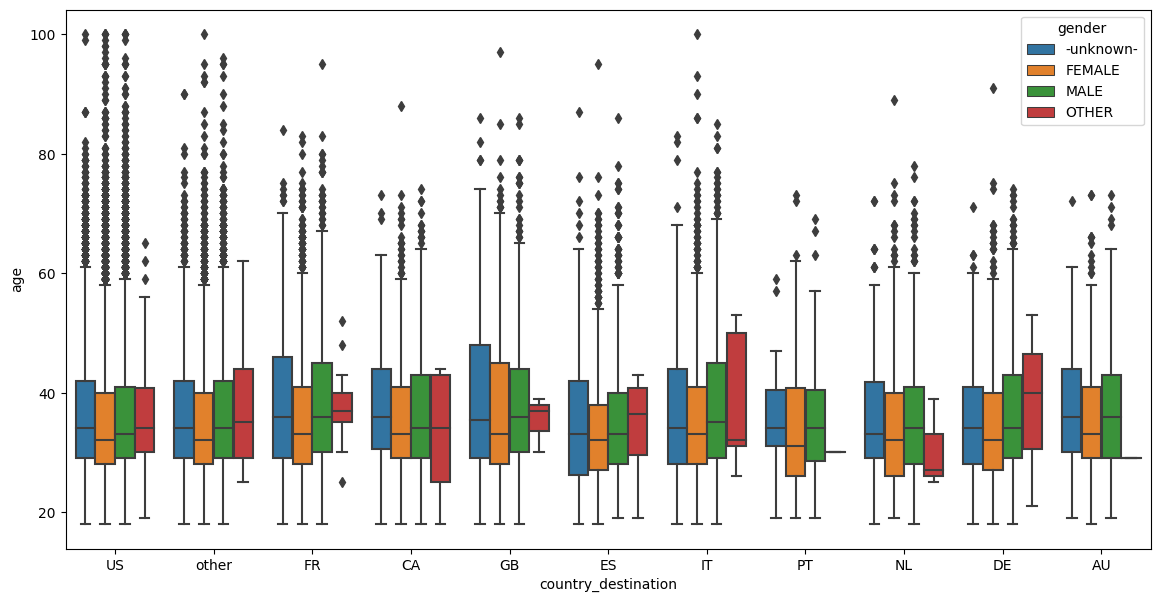

In [375]:
plt.figure(figsize=[14,7])
sns.boxplot(data=df_users,y='age',x='country_destination',hue='gender')

1. Male users are older compared to females in people who are travelling
2. Yonger female users prefer to travel countries like ES, PT and NL.
3. Older users whose gender is other usually book a travel to IT while younger users of the same gender tend to go to CA.


## Time series 
1. Seasonality of activaties stands out where more is seen in summary time than in winter time.
2. These three time series variables are trending in a similar way.
3. The drop at the end for 'first_booking_per_day' is due to lack of data provided.

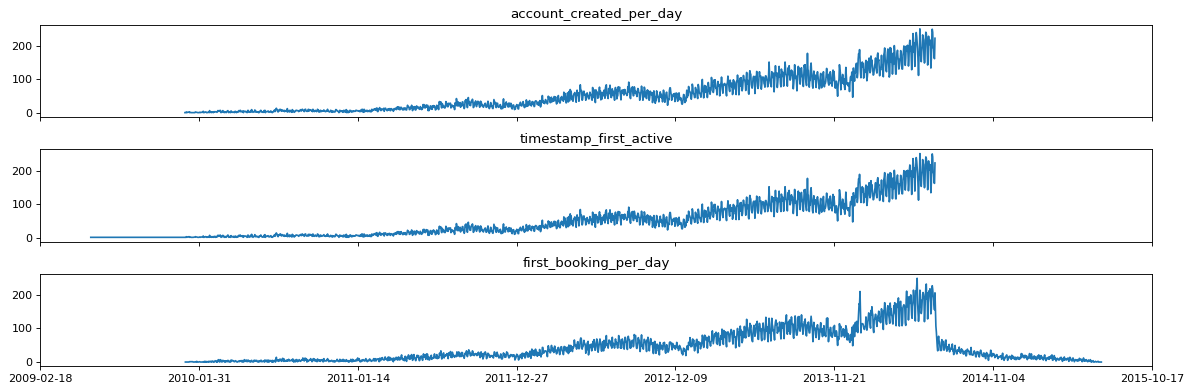

In [376]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 5), dpi=80, facecolor="w", edgecolor="k",sharex=True)
dac=df_users.date_account_created.value_counts().sort_index()
axes[0].plot(dac)
axes[0].set_title('account_created_per_day')

dfa=df_users.timestamp_first_active.value_counts().sort_index()
axes[1].plot(dfa)
axes[1].set_title('timestamp_first_active')

dfb=df_users.date_first_booking.value_counts().sort_index()
axes[2].plot(dfb)
axes[2].set_title('first_booking_per_day')

ymin, ymax = axes[1].get_xlim()
axes[1].set_xticks(np.round(np.linspace(ymin, ymax, 8), 2))
# axes.tick_params('x',labelrotation=90)
plt.tight_layout()
